In [18]:
%matplotlib inline
import Quandl
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd
import scipy.stats
import pylab

np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False

In [33]:
## NUMBER OF ASSETS
n_assets = 6

## NUMBER OF OBSERVATIONS
n_obs = 1000

#return_vec = np.random.randn(n_assets, n_obs)
return_vec = np.matrix(get(['MSFT','AAPL','IBM','HP','ORCL','INTC'], 'log_returns')).T


In [40]:
def get(ticker_list, kind = 'returns'):
    #takes in a ticker list and returns either a dataframe of closing price 'returns'
    #for each stock or closing 'prices'
    final_df = pd.DataFrame()
    for item in ticker_list:
        ticker = item
        temp_df = Quandl.get('YAHOO/'+str(ticker), 
                                         trim_start='2000-01-01', trim_end='2015-01-01', collapse='monthly', authtoken="H4uWGQ3jQdm96V7H2Abm")
        temp_df.index = pd.to_datetime(temp_df.index)
        temp_df = temp_df.sort()
        if (kind == 'prices'):
            add_series = temp_df.Close
        elif (kind == 'log_prices'):
            add_series = np.log(temp_df.Close);
        elif (kind == 'returns'):
            add_series = temp_df.Close.shift(-1) - temp_df.Close
            #add_series.ix[:-1]
        else:
            add_series = np.log(temp_df.Close).shift(-1) - np.log(temp_df.Close)
        final_df[ticker] = add_series
        

    final_df = final_df.sort().ix[:-1]
    return final_df

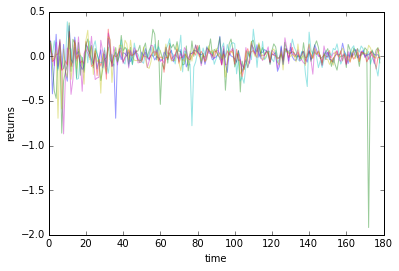

In [41]:
plt.plot(return_vec.T, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns')


In [42]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

print rand_weights(n_assets)
print rand_weights(n_assets)

[ 0.10701068  0.31051357  0.1315038   0.0783651   0.06302845  0.3095784 ]
[ 0.17980118  0.1266294   0.17295717  0.12219554  0.15010358  0.24831313]


In [43]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    #print 'p:\n'
    #print p
    
    w = np.asmatrix(rand_weights(returns.shape[0])).T
    #print 'w:\n'
    #print w
    C = np.asmatrix(np.cov(returns))
    #print 'C:\n'
    #print C
    
    mu = w.T * p
    sigma = np.sqrt(w.T * C * w)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

#random_portfolio(return_vec)

In [44]:
n_portfolios = 1000
means, stds = np.column_stack([
    random_portfolio(return_vec) 
    for _ in xrange(n_portfolios)
])

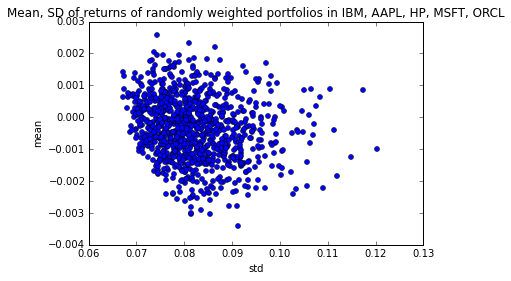

In [45]:
plt.plot(stds, means, 'o', markersize=5)
#plt.axis([0, .30, -.20, .20])
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean, SD of returns of randomly weighted portfolios in IBM, AAPL, HP, MSFT, ORCL')

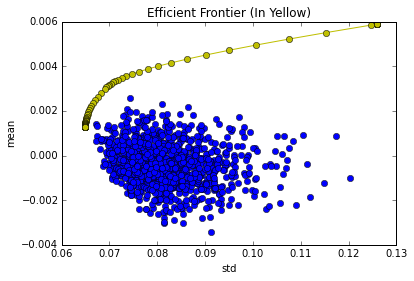

In [47]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

weights, returns, risks = optimal_portfolio(return_vec)


plt.title("Efficient Frontier (In Yellow)")
plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')